# Training Whisper with Huggingface 🤗

In my previous article, we learned about the new end-to-end speech recognition model developed by OpenAI: Whisper.

Today, we will go through the steps required to fine-tune a Whisper model using several Huggingface libraries. Furthermore, we will explore how the Huggingface libraries take care of all the different steps under the hood, and how the model learns from the training examples.

But first, let me clarify an important point: Whisper models are already trained on downstream tasks, which means that they can be used out-of-the-box to perform several tasks like language-to-language transcription, language-to-english translation, and language identification. However, you will achieve better performance on specific distributions (language, domain, a particular background noise, ...) if the model is fine-tuned on a a specific dataset.

If you want to learn more about approach used, training data, model architecture, and the extensive evaluation performed by the OpenAI team, [this](https://marinone94.github.io/Whisper-paper/) is the place to start! You will benefit much more from this post afterwards.

Since the scope of the article is to learn about the training process, we will fine-tune the smallest model available - [Whisper Tiny](https://huggingface.co/openai/whisper-tiny) - on the Swedish subset of the [Fleurs](https://huggingface.co/datasets/google/fleurs) dataset. Whisper models have been trained largely on English data, so they have more margin for improvement on lower-resource languages.

## How to read this article

This article follows a quite standard flow and starts by introducing the datastet - loaded in streaming mode - and the evaluation metric. Then, it will dive deep into the training chapter, which is made of two sections. The first one is a step-by-step guide on how to fine-tune the model using the 🤗 Trainer. The second one looks inside the engine, and explains what happens in a single training step: loading a data batch, forward pass, loss computation, backpropagation, and optimization. It does not use the 🤗 Trainer, instead it is implemented in PyTorch. Of course, you should read both! But if you are just interested into getting a fine-tuning job to work, then skip the second section. If instead you are just curious to know what happens inside the engine but you don't plan to fine-tune the model using the 🤗 Trainer any time soon, then get back to the first section when the time comes!

I strongly advise you to play with the [notebook](link) to truly understand all the bits and pieces. To smoothly run the code, you can follow the instructions in the [Environment setup](##environment-setup) chapter.

The following chapters are somewhat self-contained, meaning that they import all the required packages and define (and re-define) methods and classes so that they can run independently from each other.

## Environment setup

**⚠ Skip this chapter if you will just read the article without running any code.**

To reproduce the following examples, I recommend you to setup a virtual environment if you are running this notebook on your local machine. The code has been tested with the packages listed in the `requirements.txt` file on `Colab` and `Python 3.9.16`, so I cannot guarantee that it will run smoothly with other packages or Python versions (although it will mostly do with minimal adjustments).

In [ ]:
## Clean directories
## RUN WITH CARE!
# !rm -rf assets/ model/ wandb/

In [ ]:
# !python3.8 -m venv venv
# !source venv/bin/activate

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install huggingface-hub==0.15.1

Last, since the purpose of training a model is to use it afterwards, we will leverage the 🤗 Hub to store it, so we can load it anywhere. Model and repo will be used in future articles, so don't skip these steps! First of all, you need to create an account on https://huggingface.co (even though - if you are reading this - chance is high you already have one).

Then, you can authenticate and create a repository. It is a standard git repo, and it leverages git-lfs to manage large files like the model weights. If git-lfs is not installed, let's install it now so we can push our model later. Since on Colab it comes pre-installed, I commented out the installation cell.

In [ ]:
!git-lfs -v

In [ ]:
# !curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
# !sudo apt-get install git-lfs

Then we can login to 🤗, create, and clone the repo. The login token can be set on the [🤗 site](https://huggingface.co/settings/tokens). Make sure to give it `write` permissions, and a meaningful name. It is recommended to use differnt tokens for different scopes.

In [ ]:
!git config --global credential.helper store
!huggingface-cli login

In [5]:
# feel free to edit the name
repo_name = "whisper-training-blog"

In [ ]:
!huggingface-cli repo create $repo_name -y

In [7]:
# this returns a IPython.utils.text.SList
hf_user = !huggingface-cli whoami | head -1
# so we take the first (and only) element
hf_user = hf_user[0]
repo_url = f"https://huggingface.co/{hf_user}/{repo_name}"

In [8]:
!echo {repo_url}

https://huggingface.co/marinone94/whisper-training-blog


In [ ]:
!git clone $repo_url

This will allow us to push the model during training, or after training is completed!

In [ ]:
!pip install --upgrade -r whisper-training-blog/colab_requirements.txt

Let's check that the packages have been installed correctly, and see if a GPU is available.

In [ ]:
!pip3 freeze

In [ ]:
!nvidia-smi

Now we are ready. Let's move on to explore the dataset!

## Training dataset

Fleurs is a speech dataset open-sourced by Google which contains approximately 2000 examples for each language. Each training set has around 10 hours of supervision, and speakers of the training sets are different from the speakers of the dev and test sets.

This dataset has also been used to evaluate the translation capabilities of Whisper models, since most sentences are translated in all languages and can be matched using their ids.

Before proceeding with the training, let's take a look at the data.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("google/fleurs", "sv_se", streaming=True)

In [14]:
dataset

{'train': <datasets.iterable_dataset.IterableDataset at 0x7fbee4575d80>,
 'validation': <datasets.iterable_dataset.IterableDataset at 0x7fbee4576320>,
 'test': <datasets.iterable_dataset.IterableDataset at 0x7fbe3e3ab7c0>}

As you can see, the dataset contains three splits. Each split is an IterableDataset, since we have loaded it in streaming mode. This means that the dataset is not downloaded, but it is loaded on the fly when needed. This is useful when the dataset occupies too much space on the disk, or if you want to avoid waiting for the whole dataset to be downloaded. Huggingface [docs](https://huggingface.co/docs/datasets/stream) are excellent to learn more about the datasets library and the streaming mode.

We can check the dataset features without downloading the data. So let's have a look.

In [15]:
from pprint import pprint

features = dataset['train'].features
pprint(features)

{'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'gender': ClassLabel(names=['male', 'female', 'other'], id=None),
 'id': Value(dtype='int32', id=None),
 'lang_group_id': ClassLabel(names=['western_european_we',
                                    'eastern_european_ee',
                                    'central_asia_middle_north_african_cmn',
                                    'sub_saharan_african_ssa',
                                    'south_asian_sa',
                                    'south_east_asian_sea',
                                    'chinese_japanase_korean_cjk'],
                             id=None),
 'lang_id': ClassLabel(names=['af_za',
                              'am_et',
                              'ar_eg',
                              'as_in',
                              'ast_es',
                              'az_az',
                              'be_by',
                              'bg_bg',
                              'b

Alright, so we can see that the dataset contains a bunch of features we could use for different purposes. To train our speech recognition model, we will use only the `audio` and `raw_transcription` features. But let's look at a sample to see what values the other fields can take. Remember that we loaded the dataset in streaming mode, so we can't access it through indexes since we don't have it in memory yet! By casting it to a list though, the data points will be loaded.

In [16]:
# Get a random sample
dataset_head = dataset['test'].shuffle(1994).take(1)
# Actually download the first item and pprint it
sample = list(dataset_head)[0]
pprint(sample)

{'audio': {'array': array([ 0.00000000e+00, -5.96046448e-08,  5.96046448e-08, ...,
        3.28928232e-03,  2.80916691e-03,  2.16770172e-03]),
           'path': 'test/8553188658088956431.wav',
           'sampling_rate': 16000},
 'gender': 0,
 'id': 1851,
 'lang_group_id': 0,
 'lang_id': 85,
 'language': 'Swedish',
 'num_samples': 113280,
 'path': None,
 'raw_transcription': 'Ripströmmar är det återvändande flödet från vågor som '
                      'bryter av vid stranden, ofta vid ett rev eller '
                      'liknande.',
 'transcription': 'ripströmmar är det återvändande flödet från vågor som '
                  'bryter av vid stranden ofta vid ett rev eller liknande'}


So, the `audio` feature is a dictionary containing the audio waveform stored as numpy array, the file path, and the sampling rate. The `raw_transcription` feature is a string containing the transcription of the audio file. Let's listen to it.

In [17]:
# This download function is used to embed the files in the blog post.
import os

from scipy.io.wavfile import write

def save_wav(data, filename, sample_rate, overwrite=False):
    # Create dir if missing
    if not os.path.exists(filename) or overwrite is True:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        write(filename, sample_rate, data)
        print(f"Saved {filename} with sampling rate {sample_rate}")
    else:
        print(f"File {filename} already exists. Skipping.")


In [18]:
# Notebook visualization
from IPython.display import Audio

print(sample["raw_transcription"])
Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

Ripströmmar är det återvändande flödet från vågor som bryter av vid stranden, ofta vid ett rev eller liknande.


In [ ]:
save_wav(
    data=sample["audio"]["array"],
    filename="src/whisper_training/assets/audio/fleurs_sv/random_sample.wav",
    sample_rate=sample["audio"]["sampling_rate"]
)

As you can hear, the audio is clear but the reader speaks quite fast. The model should perform well, but most likely it won't be perfect. Let's have a look at the transcription. I will not explain each step here, but you can read all the details in my previous [article](https://marinone94.github.io/Whisper-paper/).

In [ ]:
import time

import torch
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration
)

# If you have a GPU, it will be faster...
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load processor for audio and text
# feature processor (audio) + tokenizer (text)
processor = WhisperProcessor.from_pretrained(
    "openai/whisper-tiny")

# Load model architecture and weights
model = WhisperForConditionalGeneration.from_pretrained(
    "openai/whisper-tiny").to(device)


In [21]:
model_def_max_length = model.config.max_length

def transcribe(sample, return_pred_and_ref=False, print_results=False):
    if print_results is False and return_pred_and_ref is False:
        raise ValueError("Results are not printed nor returned.\n" +
                         "Set return_pred_and_ref to return results.\n" +
                         "Set print_results to print results to console.")

    # Load audio file (see previous cells)
    data = sample["audio"]["array"]
    sampling_rate = sample["audio"]["sampling_rate"]
    print("Audio loaded. Sample rate: ", sampling_rate)

    # Convert input audio to log-mel spectrogram
    input_features = processor(
        data, sampling_rate=sampling_rate, return_tensors="pt").input_features.to(device)

    # Get tokens to initiate transcription
    # and store them in the model config.
    # Under the hood, this will force the model to predict
    # these tokens in the beginning of the transcription.
    init_tokens = processor.get_decoder_prompt_ids(
        language="sv", task="transcribe", no_timestamps=True)
    model.config.forced_decoder_ids = init_tokens

    # Generate transcription tokens
    print("Generating transcription...")
    st = time.perf_counter_ns()
    transcription_token_ids = model.generate(
        input_features, max_new_tokens=model_def_max_length)
    et = time.perf_counter_ns()
    dt = (et - st) / 1e9
    print(f"Transcription generated in {dt} [s]")

    # Decode transcription
    # NOTE: input_features is a batch of one element,
    # and the returned token ids are batched analogously
    transcription_token_ids = transcription_token_ids[0]
    whisper_transcript = processor.decode(
        transcription_token_ids, skip_special_tokens=True).strip()

    # Print results and return if required
    reference_transcript = sample["raw_transcription"]
    if print_results is True:
        print("Whisper transcript:\n", whisper_transcript)
        print("Reference transcript:\n", reference_transcript)
    if return_pred_and_ref is True:
        return {
            "prediction": whisper_transcript,
            "label": reference_transcript
        }


In [22]:
transcribe(sample, print_results=True)

Audio loaded. Sample rate:  16000
Generating transcription...
Transcription generated in 7.358902868 [s]
Whisper transcript:
 Ljipströmmer är åtvänderna för att få gågår från butra av i ständen. Ofta vi treväll liknande.
Reference transcript:
 Ripströmmar är det återvändande flödet från vågor som bryter av vid stranden, ofta vid ett rev eller liknande.


We can see that the generated and the reference transcripts are far from identical. As said, we are using the smallest model available, and I can guarantee you the large and medium models are mindblowing! Still, one might want to use the tiny model for different reasons (latency, memory footprint, learning, ...): then fine-tuning is definitely required, at least in Swedish! I will never get tired to repeat that also the largest models benefit from fine-tuning, especially on very specific distributions and for low-resource languages. Since there are multiple reasons to fine-tune pretrained models, let's learn everything about it.

The first pillar of improving anything is measuring! If you don't measure something, you won't know if the direction you have taken is the right one. The question is then straightforward: how do we measure the performance of the model? It is almost time to introduce the standard evaluation metric for speech recognition: the [Word Error Rate](#word-error-rate).

But before that, we should inspect the dataset a bit more. Let's load 100 random samples and look at the distribution of audio duration and transcription length (measured in number of tokens).

The audio duration is not directly provided, but we can calculate it as the ratio between the number of samples and the sampling rate. Let's keep only the features used for the analysis.

In [23]:
# Remove all unnecessary columns
cols_to_keep = ["audio", "raw_transcription", "num_samples"]
cols_to_remove = [col for col in sample.keys() if col not in cols_to_keep]
dataset = dataset.remove_columns(cols_to_remove)
# First shuffle, then take 100 samples
samples = dataset['train'].shuffle(94).take(100)
sampling_rate = sample["audio"]["sampling_rate"]
samples.features

{'num_samples': Value(dtype='int32', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'raw_transcription': Value(dtype='string', id=None)}

Since the dataset is in streaming mode, we cannot use the `dataset.to_pandas()` method. Instead, we loop over the dataset and store each item in a list: this forces the data to be downloaded. Only then we can create our dataframe.

In [24]:
import pandas as pd
from tqdm import tqdm


rows = [row for row in tqdm(samples)]
df = pd.DataFrame(rows, columns=list(samples.features.keys()))

def audio_length(ns):
    return round(ns / sampling_rate, 2)

def tokenize(text):
    return processor.tokenizer.tokenize(text)

df["audio_length"] = df["num_samples"].apply(audio_length)
df["tokens"] = df["raw_transcription"].apply(tokenize)
df["num_tokens"] = df["tokens"].apply(len)

df.head()

100it [00:45,  2.21it/s]


,num_samples,audio,raw_transcription,audio_length,tokens,num_tokens
0,182400,"{'path': None, 'array': [0.0, -3.0517578125e-0...",Detta är särskilt populärt bland nyutexaminera...,11.40,"[D, etta, ĠÃ¤r, Ġs, Ã¤r, sk, ilt, Ġpopul, Ã¤rt...",45
1,193920,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...","Samtidigt försökte den tyska flottan, främst m...",12.12,"[S, amt, id, igt, ĠfÃ¶rsÃ¶, kte, Ġden, Ġ, t, y...",38
2,243840,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Att bära åt andra - Lämna aldrig dina väskor u...,15.24,"[Att, Ġb, Ã¤, ra, ĠÃ¥t, Ġandra, Ġ-, ĠL, Ã¤m, n...",40
3,201600,"{'path': None, 'array': [0.0, 0.0, 0.0, 0.0, 0...",Sådana framgångssagor minskade förändringsskrä...,12.60,"[S, Ã¥, d, ana, Ġfram, g, Ã¥ng, ss, ag, or, Ġm...",43
4,139200,"{'path': None, 'array': [0.0, 0.0, -3.05175781...",En välbärgad resenär skulle kanske överväga en...,8.70,"[En, ĠvÃ¤l, b, Ã¤r, g, ad, Ġres, en, Ã¤r, Ġsku...",31


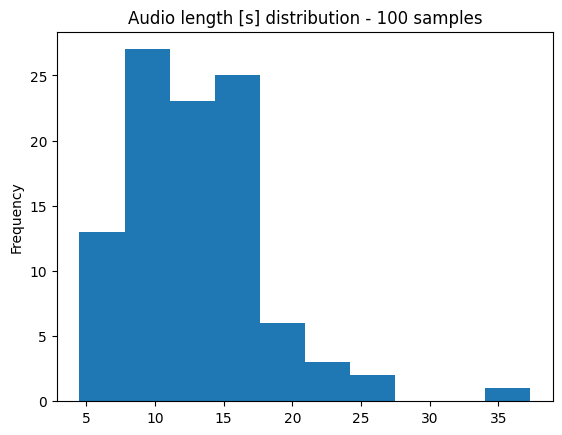

In [25]:
import matplotlib.pyplot as plt

# Plot the histogram
df.audio_length.plot(kind='hist', bins=10)

# Show the plot
plt.title(f"Audio length [s] distribution - {len(df)} samples")
plt.show()

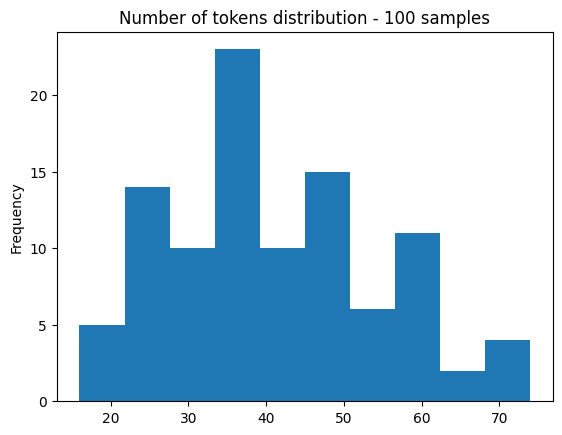

In [26]:
# Plot the histogram
df.num_tokens.plot(kind='hist', bins=10)

# Show the plot
plt.title(f"Number of tokens distribution - {len(df)} samples")
plt.show()

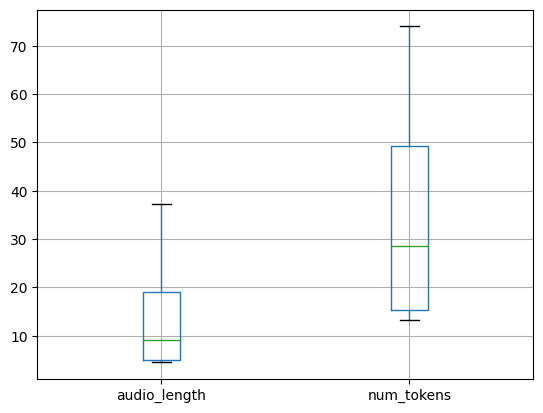

In [27]:
stats_df = pd.DataFrame({
    "mean": [df.audio_length.mean(), df.num_tokens.mean()],
    "std": [df.audio_length.std(), df.num_tokens.std()],
    "min": [df.audio_length.min(), df.num_tokens.min()],
    "max": [df.audio_length.max(), df.num_tokens.max()],
}, index=["audio_length", "num_tokens"]).T
stats_df
stats_df.boxplot()
plt.show()

Most of the randomly selected examples are shorter than 30 seconds. It is relatively safe to assume then that only a few examples will be truncated during training. Most of the samples have between 20 and 50 tokens, corresponding to audios between 5 and 20 seconds. Therefore, this dataset might not be the best to fine-tune a model which will then be used to transcribe single words. This is just to remind us that we rarely have one dataset which is perfect for all the tasks we want to perform, and it is worth spending some time to understand the dataset before jumping into the training.

## Word Error Rate

Now that we know a bit more about the dataset, we can introduce the [Word Error Rate](https://en.wikipedia.org/wiki/Word_error_rate) (WER) metric. WER measures the amount of errors in the generated transcript - the transcript, from now on - compared with the reference transcript - the reference, from now on - which we assume is the correct one.

Errors can be of three kinds: Insertions (i.e. words that are added in the transcript, but were not present in the reference), Deletions (i.e. words that are present in the reference, but  not in the transcript), and Substitutions (ie. words which are wrongly transcribed, for example `The meat was great!` vs `The meal was great!` has 1 substitution (`meal` -> `meat`).

WER is then calculated as follows:
$$
WER = (S + I + D) / N
$$

where N is the number of words of the reference.

As you can see from the definition, the WER metric measures **only** the amount of words which are wrongly transcribed, with no understanding at all about those differences. Have a look at the following examples, where the first word is the reference, and the second is the transcript:

* `Hi` -> `hi`
* `5` -> `five`
* `cool`-> `cool!`

This list could go longer (currency, units of measure, ...) but you can already see my point. If the text is not normalized before calculating the metric, the results will look much worse than they actually are! So don't forget that important step. Whisper comes with a default normalizer to facilitate experiments comparison, therefore will use that.

Still, if two words are different, one is added, or missed, they will count as 1 Substitution, 1 Insertion, or 1 Deletion respectively, regardlesss of their meanings in the context. Take those two examples:

* `The meal was great` -> `The meal was not great`
* `Ì studied Spanish at school` -> `Ì have studied Spanish at school`

The first Deletion completely swap the sentence meaning, while the second one is basically harmless, but they both impact WER the same way!

Let's now calculate the WER of the long example. We will use the WER implementation provided by 🤗 Evaluate, as we should not reinvent the wheel unless we can make a better one. Note that the BasicTextNormalizer is language agnostic. For accurate evaluation, I advise implementing language specific normalizers.

In [ ]:
import evaluate
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

metric = evaluate.load("wer")
normalizer = BasicTextNormalizer()

In [29]:
def wer(pred, label):
    # wer <= 1, we make it as %
    # and it wants list of predictions and references, not strings
    norm_pred = normalizer(pred)
    norm_label = normalizer(label)
    wer = 100 * metric.compute(predictions=[pred], references=[label])
    wer = round(wer, 2)

    print("-"*45)
    print("Prediction:", pred)
    print("Reference:", label)
    print("WER", wer)
    print("-"*45)

    norm_wer = 100 * metric.compute(predictions=[norm_pred], references=[norm_label])
    wer = round(wer, 2)

    print("Normalised prediction:", norm_pred)
    print("Normalised reference:", norm_label)
    print("WER", norm_wer)

    return wer, norm_wer

In [30]:
response = transcribe(sample, return_pred_and_ref=True)
pred, label = response["prediction"], response["label"]
raw_wer, norm_wer = wer(pred, label)

Audio loaded. Sample rate:  16000
Generating transcription...
Transcription generated in 0.341825522 [s]
---------------------------------------------
Prediction: Ljipströmmer är åtvänderna för att få gågår från butra av i ständen. Ofta vi treväll liknande.
Reference: Ripströmmar är det återvändande flödet från vågor som bryter av vid stranden, ofta vid ett rev eller liknande.
WER 83.33
---------------------------------------------
Normalised prediction: ljipströmmer är åtvänderna för att få gågår från butra av i ständen ofta vi treväll liknande 
Normalised reference: ripströmmar är det återvändande flödet från vågor som bryter av vid stranden ofta vid ett rev eller liknande 
WER 77.77777777777779


We can observe again that the model has a hard time transcribing this sample. But we can also see how normalization can affect the WER. Here a basic normalization reduces the WER of about 9%, since a substitution was "." for "," which is extremely hard for the model to predict and either could be correct. Therefore, these normalization techniques allow for better model's capabilities assessment.

Yeah, WER probably is not the best metric possible, but it does not require human judgment, so it is scalable and somehow consistent. And it is the standard metric used in ASR research, so we will use it. For now.

## Beyond WER

Having seen the limitations of WER, it is worth mentioning that other approaches can be used to either replace or integrate WER. This is a research topic on itself, so I will not write about here, but let me know if you are interested about it and I can make another article about it! Little spolier: I am thinking about using NER to discard Entities like personal or organization names, and using word and sentence embeddings to weight errors. But keep this little secret between the two of us 😉

## Training

In this paragraph, we will finally fine-tune our model on the dataset we just introduced. Then, we will compare the performance of the original and the fine-tuned models, and we hope to see a decline in the WER.

The paragraph is split into two main parts: in the first one, we will go through the steps required to fine-tune the model using multiple 🤗 libraries. In the second part, we will open the engine and figure out what happens under the hood when the model learns from the training samples.

If you are familiar with fine-tuning Speech Sequence to Sequence models with 🤗, or if you are just curious to know what happens during training, you can jump to the second part. If you don't care about what happens, and you are happy enough with being able to fine-tune a model yourself, the first part will be enough. The full training script and requirement file are available on my [GitHub](https://github.com/marinone94/whisper-inquiry/tree/main/src/whisper_training), and it should run out of the box (but go through it, you might need to change a couple of hyperparameters and set the correct flags).

Most of the code comes from the script provided during the 🤗 Whisper Fine-Tuning Event, but it has been slimmed to focus on the essential parts, and it will be expained along the way. In my way.

### Fine-tuning Whisper with 🤗


To get started, let's import the required libraries.

In [31]:
import os  # used to create output directory
import shutil  # used to remove checkpoints before pushing
from dataclasses import dataclass  # used to define data collator
from math import ceil  # used to round up decimals

import evaluate  # used to import and compute evaluation metrics
import torch  # used to know if a GPU with CUDA is available
import wandb  # used for experiment tracking
from datasets import DatasetDict, IterableDatasetDict, load_dataset  # used to load the dataset in streaming mode
from transformers import (
    AutoConfig,  # used to load model configurations
    AutoModelForSpeechSeq2Seq,  # used to load the model architecture and weights
    AutoProcessor,  # used to load the Whisper processor, which includes a feature extractor and a tokenizer
    Seq2SeqTrainer,  # used to perform training and evaluation loops
    Seq2SeqTrainingArguments,  # used to define training hyperparameters
    TrainerCallback,  # used to shuffle the training data after each epoch
    WhisperProcessor  # used for static data typing 
)
from transformers import set_seed  # used for reproducibility
from transformers.models.whisper.english_normalizer import BasicTextNormalizer  # used to normalize transcript and reference before evaluation
from transformers.trainer_pt_utils import IterableDataset, IterableDatasetShard  # used to shuffle the training data after each epoch 


Then, we will load processor, model configuration, architecture and weights, and the dataset (in streaming mode). The Swedish split of Fleurs is not a massive dataset, thus we could easily download it and store it in memory, but it is good to learn how to use the streaming mode if you were to fine-tune your model on larger datasets. 

In [32]:
model_id = "openai/whisper-tiny"
processor = AutoProcessor.from_pretrained(model_id)
config = AutoConfig.from_pretrained(model_id)
model = AutoModelForSpeechSeq2Seq.from_pretrained(model_id)

In [33]:
dataset_id = "google/fleurs"
dataset_language_code = "sv_se"
dataset = load_dataset(dataset_id, dataset_language_code, streaming=True)

The first time you run this code, make sure everything works fine using a small sample and low number of training steps. Just uncomment the next cell and run it. One note: since the dataset is loaded in streaming mode, the instruction will not be executed immediately. Instead, the dataset will be subsampled only when data will be needed during training.

In [34]:
# test_script = True
test_script = False

In [35]:
## Sample dataset for testing
if test_script is True:
    if isinstance(dataset, IterableDatasetDict):
        dataset["train"] = dataset["train"].shuffle(seed=42).take(8)
        dataset["validation"] = dataset["validation"].shuffle(seed=42).take(4)
        dataset["test"] = dataset["test"].shuffle(seed=42).take(4)
    elif isinstance(dataset, DatasetDict):
        dataset["train"] = dataset["train"].shuffle(seed=42).select(range(8))
        dataset["validation"] = dataset["validation"].shuffle(seed=42).select(range(4))
        dataset["test"] = dataset["test"].shuffle(seed=42).select(range(4))

The raw dataset is not yet ready for training. As described in my first article about Whisper, the input audio waveform needs to be transformed into a Log-mel Spectrogram. I recommend you to read the [Audio Preprocessing section](https://marinone94.github.io/Whisper-paper/#audio-preprocessing) to understand the process. For the scope of this article, you should just know that the audio is translated from the time domain to its frequency representation using a sliding window, and adjusted to simulate human hearing. The Whisper Feature Extractor included in the Whisper Processor will take care of the rest.

Furthermore, the reference transcripts need to be tokenized since the model outputs one token at the time and they are used to compute the loss during training. Again, the Tokenizer will take care of that, but the task needs to be included in the preprocessing step.

When we introduced the WER metric, we learned about the importance of normalizing the texts. But should we do that also before training? That is up to you, but you should remember that Whisper models have been pretrained to predict Capitalization, digits, and punctuation. So if you normalize the reference teanscripts before fine-tuning, you will teach your model not to predict capital letters, digits, and punctuations. This does not mean that the model will never predict them, since it has been extensively pretrained to do so. To wrap up, your choice should depend on the final application and on the dataset size, but in general I recommend not to normalize the references before training.

Finally, by storing the input features in the default model input name, the trainer will automatically pick the correct ones during training. So, don't hard-code it!

In [36]:
dataset_id = "google/fleurs"
dataset_language_code = "sv_se"
dataset = load_dataset(dataset_id, dataset_language_code, streaming=True)

###

normalizer = BasicTextNormalizer()
# model_input_name = 'input_features'
model_input_name = processor.feature_extractor.model_input_names[0]

def prepare_dataset(batch, normalize=False):
    # process audio
    sample = batch["audio"]
    inputs = processor.feature_extractor(sample["array"], sampling_rate=sample["sampling_rate"])
    # process audio length
    batch[model_input_name] = inputs.get(model_input_name)[0]
    batch["input_length"] = len(sample["array"])

    # process targets
    if normalize is True:
        labels = batch["raw_transcription"].lower()
        labels = normalizer(labels).strip()
    else:
        labels = batch["raw_transcription"].strip()
    batch["labels"] = processor.tokenizer(labels).input_ids
    return batch

###

# dataset["train"].features is like a dict
# train, validation and test splits have the same features
raw_datasets_features = list(dataset["train"].features.keys())
preprocessed_dataset = IterableDatasetDict()

preprocessed_dataset["train"] = dataset["train"].map(
    prepare_dataset,
    remove_columns=raw_datasets_features,
    fn_kwargs={"normalize": False},  # needed only if default value and provided value differ
).with_format("torch")
preprocessed_dataset["validation"] = dataset["validation"].map(
    prepare_dataset,
    remove_columns=raw_datasets_features,
    fn_kwargs={"normalize": False},  # reference transripts are normalized in the evaluation function
).with_format("torch")
preprocessed_dataset["test"] = dataset["test"].map(
    prepare_dataset,
    remove_columns=raw_datasets_features,
    fn_kwargs={"normalize": False},  # reference transripts are normalized in the evaluation function
).with_format("torch")

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:

    processor: WhisperProcessor
    decoder_start_token_id: int

    def __call__(self, features):
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        model_input_name = self.processor.model_input_names[0]
        input_features = [{model_input_name: feature[model_input_name]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)


We will use the `.map` method to apply our preprocessing function to the whole dataset. At the same time, we will drop all the columns which are not strictly needed during training. Since `input_features`, `ìnput_length` and `labels` are not features of the raw dataset, we can remove all the original ones. Finally, we will convert the dataset features to `torch` type since the dataset has no `__len__` property (again, we are in streaming mode). 

In [39]:
# dataset["train"].features is like a dict
# train, validation and test splits have the same features
raw_datasets_features = list(dataset["train"].features.keys())
preprocessed_dataset = IterableDatasetDict()

preprocessed_dataset["train"] = dataset["train"].map(
    prepare_dataset,
    remove_columns=raw_datasets_features,
    fn_kwargs={"normalize": False},  # needed only if default value and provided value differ
).with_format("torch")
preprocessed_dataset["validation"] = dataset["validation"].map(
    prepare_dataset,
    remove_columns=raw_datasets_features,
    fn_kwargs={"normalize": False},  # reference transripts are normalized in the evaluation function
).with_format("torch")
preprocessed_dataset["test"] = dataset["test"].map(
    prepare_dataset,
    remove_columns=raw_datasets_features,
    fn_kwargs={"normalize": False},  # reference transripts are normalized in the evaluation function
).with_format("torch")

Since we want to evaluate our model on the validation set during training, we also need to provide a method that computes the metrics given the model predictions. It looks very similar to the function we introduced above, but since it will receive a single prediction object, we need to extract the predicted tokens and the corresponding labels. Furthermore, we replace the label ids equal to -100 with the padding token. A couple of minutes of patience and you will understand why.

When decoding the prediction and the labels, we need to discard the special tokens. Those are used to force the model to perform specific tasks. You can read more [here](https://marinone94.github.io/Whisper-paper/#tasks).

In [40]:
metric = evaluate.load("wer")

def compute_metrics(pred):
    # extract predicted tokens 
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # pad tokens will then be discarded by the tokenizer with all other special tokens
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # decode transcripts and reference
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # normalize transcript and reference
    pred_str = [normalizer(pred) for pred in pred_str]
    label_str = [normalizer(label) for label in label_str]

    # only evaluate the samples that correspond to non-zero references
    pred_str = [pred_str[i] for i in range(len(pred_str)) if len(label_str[i]) > 0]
    label_str = [label_str[i] for i in range(len(label_str)) if len(label_str[i]) > 0]

    # express WER as percentage
    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

Alright, we are almost done preparing our dataset. Quite a lot of work, I know, but that is most of the job.

The last step is to define a data collator, which will build data btaches from the datasets during training using the Whisper Processor. It will also pad input features and labels.

Also, in the metrics computation method we replaced the labels with id equal to -100. It was done because the data collator "**must**" set the padding tokens to -100 so that the trainer will automatically ignore them when computing the loss. That was the reverse step.

In [41]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:

    processor: WhisperProcessor
    decoder_start_token_id: int

    def __call__(self, features):
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        model_input_name = self.processor.model_input_names[0]
        input_features = [{model_input_name: feature[model_input_name]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


In [42]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

The next step was something I would have definitely missed had I not attended the 🤗 Whisper Fine-Tuning Event. Thanks, guys, I learned a ton!

Still, there is something misterious to me, so I would love if someone explained it to me. Streaming datasets are not automatically shuffled after each epoch, therefore we define a Callback to do so. However, if we set the number of epochs in the Training Arguments (which we will see shortly), the Trainer complains that the datset has no length, and it asks us to define the maximum number of training steps. So, will this Callback ever be used? Or the Trainer will not be aware of having completed an epoch? Thanks in advance to whoever will clarify this to me! 

In [43]:
# Trainer callback to reinitialise and reshuffle the streamable datasets at the beginning of each epoch
# Only required for streaming: Trainer automatically shuffles non-streaming datasets
class ShuffleCallback(TrainerCallback):
    def on_epoch_begin(self, args, state, control, train_dataloader, **kwargs):
        if isinstance(train_dataloader.dataset, IterableDatasetShard):
            pass  # set_epoch() is handled by the Trainer
        elif isinstance(train_dataloader.dataset, IterableDataset):
            train_dataloader.dataset.set_epoch(train_dataloader.dataset._epoch + 1)


We are finally done preparing our data! But do you remember that Whisper is a multi-task Speech Recognition model? And that the task is simply induced using special prefix tokens? Good, now it is time to instruct the model. To do so, we can set those special tokens using the Tokenizer embedded in the Processor.


In [44]:
processor.tokenizer.set_prefix_tokens(language="sv", task="transcribe")

## If you wanted to get an English transcription from Swedish audio
# processor.tokenizer.set_prefix_tokens(language="sv", task="translate")

(Here you can see what happens if we define only the number of epochs. Scroll down a bit to see explanation and working implementation of Training Arguments and Trainer).

In [45]:
# Set output dir to 🤗 repo
output_dir = f"./{repo_name}"
# os.makedirs(output_dir, exist_ok=True)

In [46]:
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    num_train_epochs=2,
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=1,
    logging_strategy="steps",
    logging_steps=1,
    report_to="none",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2
)

In [47]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=preprocessed_dataset["train"],
    eval_dataset=preprocessed_dataset["validation"],
    tokenizer=processor.feature_extractor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[ShuffleCallback()]
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer_seq2seq.py:56 in __init__           │
│                                                                                                  │
│    53 │   │   optimizers: Tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LambdaLR] = (N   │
│    54 │   │   preprocess_logits_for_metrics: Optional[Callable[[torch.Tensor, torch.Tensor], t   │
│    55 │   ):                                                                                     │
│ ❱  56 │   │   super().__init__(                                                                  │
│    57 │   │   │   model=model,                                                                   │
│    58 │   │   │   args=args,                                                                     │
│    59 │   │   │   data_collator=data_collator,                                                   │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:568 in __init__                  │
│                                                                                                  │
│    565 │   │   │   logger.info("max_steps is given, it will override any value given in num_tra  │
│    566 │   │                                                                                     │
│    567 │   │   if train_dataset is not None and not has_length(train_dataset) and args.max_step  │
│ ❱  568 │   │   │   raise ValueError(                                                             │
│    569 │   │   │   │   "The train_dataset does not implement __len__, max_steps has to be speci  │
│    570 │   │   │   │   "The number of steps needs to be known in advance for the learning rate   │
│    571 │   │   │   )                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: The train_dataset does not implement __len__, max_steps has to be specified. The number of steps needs 
to be known in advance for the learning rate scheduler.

Cool, we are almost ready for training! Let's define (and create, if missing) the output directory and define some Training Arguments. You can read about all the parameterse on the [🤗 docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments).

Here, we will instruct the trainer to both train and evaluate the model, define how often metrics should be logged, evaluation should be performed on the evaluation set, model saved, and what batch size to use. The model - in this configuration - **will not be** pushed to the 🤗 hub since it is quite slow. Make sure to authenticate, create a repo and push your model if you train a large model, or use a large dataset!

We will also use mixed precision (16-bit floating point, or fp16) if we are training on a GPU.

We will also instruct the model to use the `generate` method for evaluation. That method is used for inference, and it applies a decoding technique to the predicted logits. In this case, it will use greedy search, since we set the number of beams to 1. I briefly introduced decoding algorithgms in the [Decoder paragraph](https://marinone94.github.io/Whisper-paper/#decoder) of my first article, but for now you can simply think of it as selecting the next token as the highest probability, after applying a softmax to the logits. I am considering writing a post about the impact of decoding algorithms on Whisper performance, so let me know you are interested!

Last, we can track our training using several experiment tracking tools. I use Weights and Biases - great tool, you should definitely have a look - but 🤗 supports also "azure_ml", "comet_ml", "mlflow", "neptune" and "tensorboard". You can use "all" (default) to report to all integrations installed, "none" for no integrations. Since WandB is installed in this environment, you should explicitely set it to "none" if you don't have an account.

In [48]:
## If you don't want to track your experiment with WandB, run this!
report_to = "none"

In [ ]:
# If you have a wandb account, login!
# Otherwise, edit this cell to loging with your favourite experiment tracker(s)
wandb.login()
wandb.init(project="whisper-training-post")
report_to = "wandb"

In [50]:
# Check if we have a GPU.
# In case, we will use mixed precision
# to reduce memory footprint with
# with minimal to no harm to performance
device = "cuda" if torch.cuda.is_available() else "cpu"
use_fp16 = (device == "cuda")

# Let's first define the batch sizes
# Increase it if you have more than 16GB GPU
train_bs = 4 if test_script is True else 16
eval_bs = 2 if test_script is True else 8

# Then we infer the number of steps
# TODO: how did I find it?
num_training_samples = 2385
num_epochs = 3
max_steps_full_training = ceil(num_training_samples * num_epochs / train_bs)
max_steps = 2 if test_script is True else max_steps_full_training

# We don't want to evaluate too often since it slows down training a lot
eval_steps = 1 if test_script is True else int(max_steps / 10)
logging_steps = 1 if test_script is True else int(max_steps / 100)

# Init training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    do_train=True,
    do_eval=True,
    max_steps=max_steps,  
    evaluation_strategy="steps",
    eval_steps=eval_steps,
    logging_strategy="steps",
    logging_steps=logging_steps,
    save_strategy="steps",
    save_steps=eval_steps,
    save_total_limit=3,
    learning_rate=7.5e-6,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
	  warmup_ratio=0.5 if test_script is True else 0.3,
    per_device_train_batch_size=train_bs,
    per_device_eval_batch_size=eval_bs,
    # important
    fp16=use_fp16,
    predict_with_generate=True,
    generation_num_beams=1,
    # track experiment
    report_to=report_to,
    # push model to hf hub recommended during training if
    # - training large model / on large datasets (i.e. training takes long)
    # - training on spot instances
    # if the instance crashes, you can resume your training from the checkpoint
    # see 🤗 docs for detailed instructions
    push_to_hub=False
)

Now we can provide the trainer with the model, tokenizer (important: use the one you assign language and task to! In this example, it is `processor.tokenizer`), training arguments, datasets, data collator, callback, and the method to compute metrics during evaluation.

Note that we don't need to place the model to the accelerator device, nor we had to do it in the data collator with the dataset! The trainer will take care of it, if a GPU is available.

In [51]:
# Initialize Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=preprocessed_dataset["train"],
    eval_dataset=preprocessed_dataset["validation"],
    tokenizer=processor.feature_extractor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[ShuffleCallback()]
)

I hope you haven't left yet. If you have, bad for you, as we are ready for training our model! 🍾

As Whisper is a pretrained model ready to be used off-the-shelf, it is advisable to evaluate it before training on both the validation and test sets. Let's make sure we make no harm to it.

In [52]:
eval_metrics = trainer.evaluate(
    eval_dataset=preprocessed_dataset["validation"],
    metric_key_prefix="eval_pretrained",
    max_length=448,
    num_beams=1,
    # gen_kwargs={"key": value}  to provide additional generation specific arguments by keyword
)

trainer.log_metrics("eval_pretrained", eval_metrics)
trainer.save_metrics("eval_pretrained", eval_metrics)
print(eval_metrics)

***** eval_pretrained metrics *****
  eval_pretrained_loss               =     1.7157
  eval_pretrained_runtime            = 0:03:17.02
  eval_pretrained_samples_per_second =      1.675
  eval_pretrained_steps_per_second   =      0.213
  eval_pretrained_wer                =    264.426
{'eval_pretrained_loss': 1.71565842628479, 'eval_pretrained_wer': 264.42599393262014, 'eval_pretrained_runtime': 197.0203, 'eval_pretrained_samples_per_second': 1.675, 'eval_pretrained_steps_per_second': 0.213}


In [53]:
test_metrics = trainer.evaluate(
    eval_dataset=preprocessed_dataset["test"],
    metric_key_prefix="test_pretrained",
    max_length=448,
    num_beams=1,
    # gen_kwargs={"key": value}  to provide additional generation specific arguments by keyword
)

trainer.log_metrics("test_pretrained", test_metrics)
trainer.save_metrics("test_pretrained", test_metrics)
print(test_metrics)

***** test_pretrained metrics *****
  test_pretrained_loss               =      1.725
  test_pretrained_runtime            = 0:04:33.25
  test_pretrained_samples_per_second =      2.778
  test_pretrained_steps_per_second   =      0.348
  test_pretrained_wer                =   261.9067
{'test_pretrained_loss': 1.7249696254730225, 'test_pretrained_wer': 261.9066587001262, 'test_pretrained_runtime': 273.2544, 'test_pretrained_samples_per_second': 2.778, 'test_pretrained_steps_per_second': 0.348}


In [54]:
train_result = trainer.train()
trainer.save_model()

metrics = train_result.metrics
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()
print(metrics)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
44,1.411100,1.491944,245.345681
88,1.050100,1.225460,225.882165
132,0.903200,1.120284,211.655756
176,0.814100,1.067498,184.623982
220,0.802900,1.039361,178.412901
264,0.632500,1.030140,216.637394
308,0.697100,1.013514,184.400447
352,0.605100,1.006531,194.714993
396,0.604700,1.002950,166.932780
440,0.585000,1.004960,191.234233


***** train metrics *****
  epoch                    =        2.33
  total_flos               = 163660945GF
  train_loss               =      0.8752
  train_runtime            =  0:37:40.84
  train_samples_per_second =        3.17
  train_steps_per_second   =       0.198
{'train_runtime': 2260.8457, 'train_samples_per_second': 3.17, 'train_steps_per_second': 0.198, 'total_flos': 1.7572960198656e+17, 'train_loss': 0.8751586728862354, 'epoch': 2.33}


As we can see from the training logs, both the training and evaluation losses have plateaud at a high value, and the evaluation WER has decreased but was fluctuating. There are several reasons for this: however, they go beyond the scope of the article, which is already way too long. Today we focus on HOW to fine-tune the model, and WHAT happens inside the engine. In one of the next ones, we will train the best Whisper model we can. One thing at the time.

Okay, if you really can't wait, I'll spoiler you a couple of things: the model should have been trained longer, with a higher learning rate. And maybe the batch size was too large, considering the dataset size. Hyperparameters should be searched, if compute is available. Or look at others' work, and start from there. That's why open science advances humankind's knowledge at breakneck speed, isn't it?

Alright, let's evaluate it again on the held-out test set.

In [55]:
final_metrics = trainer.evaluate(
    eval_dataset=preprocessed_dataset["test"],
    metric_key_prefix="test_finetuned",
    max_length=448,
    num_beams=1,
    # gen_kwargs={"key": value}  to provide additional generation specific arguments by keyword
)

trainer.log_metrics("test_finetuned", final_metrics)
trainer.save_metrics("test_finetuned", final_metrics)
print(final_metrics)

***** test_finetuned metrics *****
  epoch                             =       2.33
  test_finetuned_loss               =     1.0019
  test_finetuned_runtime            = 0:03:57.99
  test_finetuned_samples_per_second =      3.189
  test_finetuned_steps_per_second   =      0.399
  test_finetuned_wer                =   172.9602
{'test_finetuned_loss': 1.0018519163131714, 'test_finetuned_wer': 172.96023368518888, 'test_finetuned_runtime': 237.997, 'test_finetuned_samples_per_second': 3.189, 'test_finetuned_steps_per_second': 0.399, 'epoch': 2.33}


As we can see, the test WER has dropped 34%, so the fine-tuning is definitely improving the model's performance. But what has happened during training? I mean, we did it all with a single line of code: `trainer.train()`. To improve your models, fix problems, and come out with innovative solutions, is essential to deeply understand what happens inside the engine. That is the subject of the next section. Before that, let's clean up our working environment and try out our new model.

As said, during training checkpoints are created. Let's clean up our directory. Don't worry, your best model is saved separately, so we can still push it to the 🤗 hub :)

In [ ]:
# Pushing to hub during training slows down training
# so we push it only in the end.
# Since training is completed and best model has been saved,
# we first delete the checkpoints
for filename in os.listdir(output_dir):
    if filename.startswith("checkpoint-"):
        shutil.rmtree(f"{output_dir}/{filename}")
trainer.push_to_hub()

Now we can load the fine-tuned model from the hub and use it for inference. Note that had we done some relevant changes to the processor, we should have had pushed it as well and loaded it hereafter like the model.

In [ ]:
model_id = f"{hf_user}/{repo_name}"
model = AutoModelForSpeechSeq2Seq.from_pretrained(model_id).to(device)
processor = AutoProcessor.from_pretrained("openai/whisper-tiny")

The following code block is copied from the [Training dataset](##training-dataset) chapter. You can skip it, if you have run it above.



In [58]:
model_def_max_length = model.config.max_length

def transcribe(sample, return_pred_and_ref=False, print_results=False):
    if print_results is False and return_pred_and_ref is False:
        raise ValueError("Results are not printed nor returned.\n" +
                         "Set return_pred_and_ref to return results.\n" +
                         "Set print_results to print results to console.")

    # Load audio file (see previous cells)
    data = sample["audio"]["array"]
    sampling_rate = sample["audio"]["sampling_rate"]
    print("Audio loaded. Sample rate: ", sampling_rate)

    # Convert input audio to log-mel spectrogram
    input_features = processor(
        data, sampling_rate=sampling_rate, return_tensors="pt").input_features.to(device)

    # Get tokens to initiate transcription
    # and store them in the model config.
    # Under the hood, this will force the model to predict
    # these tokens in the beginning of the transcription.
    init_tokens = processor.get_decoder_prompt_ids(
        language="sv", task="transcribe", no_timestamps=True)
    model.config.forced_decoder_ids = init_tokens

    # Generate transcription tokens
    print("Generating transcription...")
    st = time.perf_counter_ns()
    transcription_token_ids = model.generate(
        input_features, max_new_tokens=model_def_max_length)
    et = time.perf_counter_ns()
    dt = (et - st) / 1e9
    print(f"Transcription generated in {dt} [s]")

    # Decode transcription
    # NOTE: input_features is a batch of one element,
    # and the returned token ids are batched analogously
    transcription_token_ids = transcription_token_ids[0]
    whisper_transcript = processor.decode(
        transcription_token_ids, skip_special_tokens=True).strip()

    # Print results and return if required
    reference_transcript = sample["raw_transcription"]
    if print_results is True:
        print("Whisper transcript:\n", whisper_transcript)
        print("Reference transcript:\n", reference_transcript)
    if return_pred_and_ref is True:
        return {
            "prediction": whisper_transcript,
            "label": reference_transcript
        }


The following code block is copied from the [Word Error Rate](##word-error-rate) chapter. You can skip it, if you have run it above.

In [59]:
def wer(pred, label):
    # wer <= 1, we make it as %
    # and it wants list of predictions and references, not strings
    norm_pred = normalizer(pred)
    norm_label = normalizer(label)
    wer = 100 * metric.compute(predictions=[pred], references=[label])
    wer = round(wer, 2)

    print("-"*45)
    print("Prediction:", pred)
    print("Reference:", label)
    print("WER", wer)
    print("-"*45)

    norm_wer = 100 * metric.compute(predictions=[norm_pred], references=[norm_label])
    norm_wer = round(norm_wer, 2)

    print("Normalised prediction:", norm_pred)
    print("Normalised reference:", norm_label)
    print("WER", norm_wer)

    return wer, norm_wer

In [60]:
response = transcribe(sample, return_pred_and_ref=True)
pred, label = response["prediction"], response["label"]
raw_wer, norm_wer = wer(pred, label)

Audio loaded. Sample rate:  16000
Generating transcription...
Transcription generated in 0.222633967 [s]
---------------------------------------------
Prediction: Liipströmmer är åtvänderna flödet från våger från Butravistan, ofta vid trev eller liknande.
Reference: Ripströmmar är det återvändande flödet från vågor som bryter av vid stranden, ofta vid ett rev eller liknande.
WER 61.11
---------------------------------------------
Normalised prediction: liipströmmer är åtvänderna flödet från våger från butravistan ofta vid trev eller liknande 
Normalised reference: ripströmmar är det återvändande flödet från vågor som bryter av vid stranden ofta vid ett rev eller liknande 
WER 61.11


This inspection confirms that the WER has dropped on our random sample. 

### Inside the engine

As promised, we will now look inside the engine, and understand what happens exactly when we execute `trainer.train()`. To do so, we will re-implement and analyze the main steps required to fine-tune your Whisper model.


#### Step 1: a lot of checks and setup

If you inspect the `trainer` instantiation and the `train()` method, you will see a lot of steps that Trainer performs to validate setup, input data and parameters, and enable specific behaviours. This makes the Trainer suitable to be used for hyperparameter tuning, distributed and accelerated training, and many of the techniques recently invented. This article does not want to be an exaustive introduction to 🤗 Trainer API, and since we are training the model on a single GPU without using any special algortihm nor device, we don't need to go any further.

#### Step 2: place the model to device

In step 1, the Trainer will also automatically place the model on the most suitable device (i.e. a GPU, if it is available). This will be skipped when specific training configuration like Model Parallelism or DeepSpeed are set. We will do it manually here, since we are not going to use the Trainer API. Let's reload the pretrained model once again.

In [61]:
from copy import copy, deepcopy
from dataclasses import dataclass

import torch
from datasets import IterableDatasetDict, load_dataset
from transformers import (
    AutoModelForSpeechSeq2Seq,
    AutoProcessor,
    WhisperProcessor
)
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForSpeechSeq2Seq.from_pretrained("openai/whisper-tiny").to(device)
processor = AutoProcessor.from_pretrained("openai/whisper-tiny")

#### Step 3: btach generation

As all Deep Learning models, Whisper is trained and fine-tuned in batches. This means that a bunch of examples are used together to compute the loss, and then the model parameters are updated through backpropagation. When writing a complete training loop, you will iterate over the training data and train your model one batch at the time. Here we will extract one batch and see what happens during a single iteration.

To do so, we will instantiate a Dataloader, which will take care of loading the next batch for us. It is important to understand what happens step by step, but we cannot go into the details of each line of code and rewrite everything from scratch.

The code blocks before the Dataloader instantiation are copied from the [Fine-tuning Whisper with 🤗](##fine-tuning-whisper-with-hug) chapter. You can skip it, if you have run it above.

In [63]:
dataset_id = "google/fleurs"
dataset_language_code = "sv_se"
dataset = load_dataset(dataset_id, dataset_language_code, streaming=True)

In [64]:
normalizer = BasicTextNormalizer()
# model_input_name = 'input_features'
model_input_name = processor.feature_extractor.model_input_names[0]

def prepare_dataset(batch, normalize=False):
    # process audio
    sample = batch["audio"]
    inputs = processor.feature_extractor(sample["array"], sampling_rate=sample["sampling_rate"])
    # process audio length
    batch[model_input_name] = inputs.get(model_input_name)[0]
    batch["input_length"] = len(sample["array"])

    # process targets
    if normalize is True:
        labels = batch["raw_transcription"].lower()
        labels = normalizer(labels).strip()
    else:
        labels = batch["raw_transcription"].strip()
    batch["labels"] = processor.tokenizer(labels).input_ids
    return batch

In [65]:
# dataset["train"].features is like a dict
# train, validation and test splits have the same features
raw_datasets_features = list(dataset["train"].features.keys())
preprocessed_dataset = IterableDatasetDict()

preprocessed_dataset["train"] = dataset["train"].map(
    prepare_dataset,
    remove_columns=raw_datasets_features,
    fn_kwargs={"normalize": False},  # needed only if default value and provided value differ
).with_format("torch")
preprocessed_dataset["validation"] = dataset["validation"].map(
    prepare_dataset,
    remove_columns=raw_datasets_features,
    fn_kwargs={"normalize": False},  # reference transripts are normalized in the evaluation function
).with_format("torch")
preprocessed_dataset["test"] = dataset["test"].map(
    prepare_dataset,
    remove_columns=raw_datasets_features,
    fn_kwargs={"normalize": False},  # reference transripts are normalized in the evaluation function
).with_format("torch")

In [66]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:

    processor: WhisperProcessor
    decoder_start_token_id: int

    def __call__(self, features):
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        model_input_name = self.processor.model_input_names[0]
        input_features = [{model_input_name: feature[model_input_name]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [67]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

In [68]:
dataloader = torch.utils.data.DataLoader(
    dataset=preprocessed_dataset["train"],
    batch_size=2,
    collate_fn=data_collator
)

In [69]:
batch = next(iter(dataloader))

In [70]:
batch["input_features"].shape

torch.Size([2, 80, 3000])

In [71]:
batch["labels"].shape

torch.Size([2, 57])

Here we go! The dataloader has fetched the first two examples of the dataset and built a tensor with dimension 2, as it was the desired batch size specified in the dataloader. Since the dataset is loaded in streaming mode, the iteration over the dataset has triggered two main actions: it downloaded the data, and it applied the preprocessing defined in the `prepare_dataset()`method. Last, the dataloader has used the data collator to pad the input and prepare our first batch for training the model. If you are wondering why the other dimensions are 80 and 3000, you should definiteley check the [Audio Preprocessing section](https://marinone94.github.io/Whisper-paper/#audio-preprocessing) of my previous article to learn everything about the log-mel spectrogram. It is the standard audio preprocessing in ASR.

Last, we will upload the training data to the device.

In [72]:
batch.to(device)

{'input_features': tensor([[[-0.3325,  0.1385, -0.0556,  ..., -0.8577, -0.8577, -0.8577],
         [-0.5058,  0.0516, -0.2305,  ..., -0.8577, -0.8577, -0.8577],
         [-0.3280, -0.0614, -0.1021,  ..., -0.8577, -0.8577, -0.8577],
         ...,
         [-0.8577, -0.4861, -0.5043,  ..., -0.8577, -0.8577, -0.8577],
         [-0.8577, -0.5606, -0.3973,  ..., -0.8577, -0.8577, -0.8577],
         [-0.8577, -0.6364, -0.5126,  ..., -0.8577, -0.8577, -0.8577]],

        [[-0.4111, -0.4111, -0.4111,  ..., -0.4111, -0.4111, -0.4111],
         [-0.4111, -0.4111, -0.4111,  ..., -0.4111, -0.4111, -0.4111],
         [-0.4111, -0.4111, -0.4111,  ..., -0.4111, -0.4111, -0.4111],
         ...,
         [-0.4111, -0.4111, -0.4111,  ..., -0.4111, -0.4111, -0.4111],
         [-0.4111, -0.4111, -0.4111,  ..., -0.4111, -0.4111, -0.4111],
         [-0.4111, -0.4111, -0.4111,  ..., -0.4111, -0.4111, -0.4111]]],
       device='cuda:0'), 'labels': tensor([[50363,    46,    76,  1581,   364,    85, 16082,   46

#### Step 4: forward pass

Now that we have loaded our training batch, we will execute a forward pass through the model. The output will then be compared with the labelled output to compute the loss.

Now, I don't know if you recall this detail, but in the data collator we cut the `<bos>` token in the beginning since the 🤗 Trainer appends it later. Since we are not using the 🤗 Trainer implementation, let's not forget it. I will copy-paste their implementation here.

In [73]:
def shift_tokens_right(input_ids: torch.Tensor, pad_token_id: int, decoder_start_token_id: int):
    """
    Shift input ids one token to the right.
    """
    shifted_input_ids = input_ids.new_zeros(input_ids.shape)
    shifted_input_ids[:, 1:] = input_ids[:, :-1].clone()
    shifted_input_ids[:, 0] = decoder_start_token_id

    if pad_token_id is None:
        raise ValueError("self.model.config.pad_token_id has to be defined.")
    # replace possible -100 values in labels by `pad_token_id`
    shifted_input_ids.masked_fill_(shifted_input_ids == -100, pad_token_id)

    return shifted_input_ids

In [74]:
decoder_input_ids = shift_tokens_right(
    batch.labels, model.config.pad_token_id, model.config.decoder_start_token_id
)

In [75]:
decoder_input_ids

tensor([[50258, 50363,    46,    76,  1581,   364,    85, 16082,   465,  1224,
          3239,   543,    11, 47107,  1663,  4792,   317, 16770,   741,  4816,
         17165,    70, 16684,  3307,  3775,   220, 47189, 45845,   302,   951,
          1387,  1696,  3795, 15349,  2330,   220, 47189,   372,  1330,   273,
          3307,   350, 11397, 36959,    13, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257],
        [50258, 50363, 16257, 16770,   342,  9559, 23137, 37332,  1305,  6691,
         18669,   479,    45,    12, 22882,    70,  1505,  2830,  4792,   317,
         16770,  8124,   267,    11, 15349,  5758, 35368,  5657,   391,   811,
           951,   220,  1328,  4556, 25614,   741,   272,   351,    75, 33482,
           220, 47189,  5735,   897,   266,   642,    12,  3423, 33482,    11,
           465,  1305, 25752,   271, 42554,  9140,    13]], device='cuda:0')

A quick verification will show us that we have prepended the `<bos>` token correctly.

In [76]:
def batch_decode(input_ids):
  return processor.tokenizer.batch_decode(decoder_input_ids)

In [77]:
batch_decode(decoder_input_ids)

['<|startoftranscript|><|notimestamps|>Om du använder en drönare, kontrollera ordentligt i förväg vad som är tillåtet att filma och vilka tillstånd som krävs.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>',
 '<|startoftranscript|><|notimestamps|>Enligt stämningen blev avfall från FN-lägret inte ordentligt renat, vilket fick bakterier att ta sig ned i bifloden till Artibonite-floden, en av Haitis största.']

In [78]:
outputs = model.model(batch.input_features, decoder_input_ids=decoder_input_ids)

Outputs is an instance of Seq2SeqModelOutput class implemented in 🤗 transformers library and is used in all Sequence to Sequence models. It contains the last encoder and decoder hidden states, and the accumulated key values. This must not be confused with the Seq2SeqLMOutput, which contains loss, logits, and past key values.

In [79]:
type(outputs)

transformers.modeling_outputs.Seq2SeqModelOutput

In [80]:
outputs.keys()

odict_keys(['last_hidden_state', 'past_key_values', 'encoder_last_hidden_state'])

In [81]:
outputs.last_hidden_state.shape

torch.Size([2, 57, 384])

We then use the model's head to project the last hidden decoder layer's state to the vocabulary dimension.

In [82]:
logits = model.proj_out(outputs.last_hidden_state)

#### Step 5: backpropagation

In [83]:
logits.shape

torch.Size([2, 57, 51865])

As you can see, the logits have dimensions [`batch_size`, `sequence_length`, `vocab_size`]. Now we can (let PyTorch) compute the loss. To do so, we need to concatenate the outputs.

In [84]:
from torch.nn import CrossEntropyLoss

cross_entropy_loss = CrossEntropyLoss()

In [85]:
logits_reshaped = logits.view(-1, model.config.vocab_size)
labels_reshaped = batch.labels.reshape(-1)
print(logits_reshaped.shape)
print(labels_reshaped.shape)

torch.Size([114, 51865])
torch.Size([114])


In [86]:
loss = cross_entropy_loss(logits_reshaped, labels_reshaped)
print(loss)

tensor(3.2089, device='cuda:0', grad_fn=<NllLossBackward0>)


Finally, we go to the core of deep learning. Unfortunately you cannot easily debug the gradient computation step in Pytorch, as it invokes a C++ implementation for performance reasons. Fortunatley, tones of books and blogs have been written by real experts, and they explain it much better than I ever will in this limited time.

In [87]:
loss.backward()
print(loss)

tensor(3.2089, device='cuda:0', grad_fn=<NllLossBackward0>)


In [88]:
loss = loss.detach()
print(loss)

tensor(3.2089, device='cuda:0')


As you can see, the loss has been detached by the computational graph and will not be used any longer in the backpropagation, as the gradients have already been computed. Let's optimize the model, without forgetting to clip the gradient norm. This is done to prevent the gradients from becoming too large during training and making the training process unstable. In simple words, all the gradients are downscaled proportionally to a maximum value.

In [89]:
from functools import partial

from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.nn.utils import clip_grad_norm_

In [90]:
clip_grad_norm_(model.parameters(), max_norm=1.0)

tensor(63.5967, device='cuda:0')

In [91]:
optimizer = AdamW(model.parameters(), lr=7.5e-3)

In [92]:
# from huggingface implementation
def get_linear_schedule_with_warmup_lr_lambda(current_step: int, *, num_warmup_steps: int, num_training_steps: int):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    return max(0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))

In [93]:
num_training_steps = 100  # fictious number, this is training_samples * num_epochs / batch_size
warmup_ratio = 0.3
num_warmup_steps = num_training_steps * warmup_ratio

In [94]:
# from huggingface implementation
lr_lambda = partial(
    get_linear_schedule_with_warmup_lr_lambda,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)
scheduler = LambdaLR(optimizer, lr_lambda, -1)
scheduler.step()

I hope this structure will not confuse you. In a training loop, the optimizer and the scheduler are initialized before the forward pass, but I preferred to keep them close to where they are used as we are navigating a single training step. Let's not forget to bring the scheduler a step forward, or the learning rate will be zero at the first step, meaning the paramters will not be updated.

In [95]:
optimizer.step()

In [96]:
scheduler.step()

Now the parameters have been updated based on the loss we just computed and the optimization algorithm. Last, let's not forget to reset the gradients, ready for the next batch!

In [97]:
optimizer.zero_grad()

Cool, we have just inspected the basic steps required to fine-tune a Whisper model, or actually any deep learning model via backpropagation. Just repeat this over enough, good examples with the right hyperparameters and your model will "magically" become much better.

This might look trivial for experts, but many people today are relying on the 🤗 Trainer, and are not fully aware of the basic optimization steps.

## What's next

There are a bunch of things I am curious to investigate. Since training large models is expensive, I will investigate different training approaches and platforms. We will compare time, costs, final results and - when feasible - also CO2 equivalent emissions, so you will know in advance what approach suites best.

One of the platforms I will use is Lambda Cloud, which provides GPU instances with pre-installed Deep Learning packages. At the time of writing, however, no Python client is provided, and you need to ssh into the machine to run commands. The good news is that they expose some APIs, so before the next post you will most likely get an unofficial Python client for Lambda Cloud (and maybe I will get some free credits 😅).



## Thank you!

If a single person - excluding my closest friends, who really love me - is reading this chapter, then this post will be a success. I hope you found at least one concept you were not aware of, or you didn't think of.

The AI world is running at neckbreak speed, and sometimes I feel I am too slow to produce those articles. But it helps me first, to learn and challenge my knowledge. I will get faster and better, and your feedback is precious. Don't hesitate to share it.